# Comparative between different models for TED Talks dataset

In [202]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange

# Audio
import wave
from scipy.io import wavfile

# Pruebas
import keras
from keras import backend as K
import tensorflow as tf

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate, add
from keras.layers import Conv1D, UpSampling1D, MaxPooling1D, LeakyReLU

# Only used in the custom layer for the U-Net
import tensorflow as tf

# To plot the model
from keras.utils import plot_model
from IPython.display import Image

# To play WAVs in the notebook
import IPython.display as ipd

# For the train and test split
from sklearn.model_selection import train_test_split

# Parameters, values & settings

In [2]:
# All the variables we need
samplig_rate = 16000


Due to some GPU errors

In [3]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Setting Callbacks

In [4]:
# Early Stopping:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

# Funtions

## Reading data

In [5]:
def load_df(name):
    
    print('\nOpening CSV...\n')
    df = pd.read_csv(name, index_col=[0])
    df.index = pd.RangeIndex(len(df.index))
    
    print('Reading data...\n')
    # Esto del for es canelita en rama. cinnamon in branch.
    for i in tnrange(df.shape[0]):
        #df.data[i] = np.fromstring(df.data[i].replace('[', r'').replace('\r\n', r''), sep=' ', dtype=np.int16)
        df.data[i] = np.fromstring(df.data[i].replace('[', r'').replace('\r\n', r''), sep=' ', dtype=np.float32)
        df.random_data[i] = np.fromstring(df.random_data[i].replace('[', r'').replace('\r\n', r''), sep=' ', dtype=np.float32)
        df.incompleted_data[i] = np.fromstring(df.incompleted_data[i].replace('[', r'').replace('\r\n', r''), sep=' ', dtype=np.float32)
        df.low_quality_data[i] = np.fromstring(df.low_quality_data[i].replace('[', r'').replace('\r\n', r''), sep=' ', dtype=np.float32)

    print('\nFinished successfully!')
    
    return df

## Chunk files for U-Net

In [314]:
def chunk4unet(df, col1, col2):
    
    X = []
    y = []
    
    for file in tqdm_notebook(df[col1]):
        y.append(file[:32000])
        
    for file in tqdm_notebook(df[col2]):
        X.append(file[:32000])
    
    return X, y

## Creation of train and test sets

In [6]:
def tes_tra(df):
    
    # Revistar como hacerlo bien
#     X_tr, X_te = train_test_split(df.data, test_size=0.15)

#     X_train = np.array([list(elem) for elem in X_tr.values])
#     X_test  = np.array([list(elem) for elem in X_te.values])

#     print(X_train.shape)
#     print(X_test.shape)
    
    
    return aaa

# Models

## Autoencoder

This model is a simple auto encoder-decoder

In [7]:
def simple_autoencoder(inp):
    
    input_audio = Input(shape=(inp,))
    
    # Layers
    encoded = Dense(units=1024, activation='relu')(input_audio)
    encoded = Dense(units=512, activation='relu')(encoded)

    encoded = Dense(units=256, activation='relu')(encoded)

    decoded = Dense(units=512, activation='relu')(encoded)
    decoded = Dense(units=1024, activation='relu')(decoded)

    decoded = Dense(units=32768, activation='sigmoid')(decoded)
    
    
    autoencoder = Model(input_audio, decoded)
    encoder = Model(input_audio, encoded)
    
    print('Hole autoencoder summary:')
    print(autoencoder.summary())
    print('\nEncoder summary:')
    print(encoder.summary())
    
    
    return autoencoder, encoder

## Symmetric Convolution

This model consists on a Convoltion and Deconvolution going through a bottleneck

In [8]:
def symmetric_convolution(inp):
    
    tf.enable_eager_execution()
    
    input_audio = Input(shape=(inp,))
    
    print(input_audio)
    
    # Layers
    model = Sequential()
    model.add(Conv1D(100, 10, activation='relu', input_shape = input_audio))
    model.add(MaxPooling1D(50, 2))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
    
    print('Symmetric Convolution summary:')
    print(model.summary())
    
    return model

## Wave U-Net

A 1D Convolutional Neural-Network based on the original U-Net for image segmentation: https://github.com/zhixuhao/unet

In [196]:
def unet(inp):
    
    conc_x = -1
    
    input_size = (32000, 1)
    inp_lay = Input(input_size)
    
    #Downsampling
    conv1 = Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inp_lay)
    conv1 = Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    conv3 = Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    conv4 = Conv1D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv1D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    
    # Bottleneck
    conv5 = Conv1D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv1D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Upsampling
    up6 = Conv1D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling1D(size=2)(drop5))
    merge6 = concatenate([drop4, up6], axis=conc_x)
    conv6 = Conv1D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv1D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv1D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling1D(size=2)(conv6))
    merge7 = concatenate([conv3, up7], axis=conc_x)
    conv7 = Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv1D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv1D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling1D(size=2)(conv7))
    merge8 = concatenate([conv2, up8], axis=conc_x)
    conv8 = Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv1D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv1D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling1D(size=2)(conv8))
    merge9 = concatenate([conv1, up9], axis=conc_x)
    conv9 = Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv1D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv1D(1, 1, activation='tanh')(conv9)
    
    model = Model(input=inp_lay, output=conv10)
    
    return model

In [106]:
def wave_u_net(inp):
    
    DR = 10
    
    inp_lay = keras.layers.Input(shape=(inp, 1))
    print('Input shape:', inp_lay.shape)
    
    # Downsampling layers
    x = Conv1D(filters=128, kernel_size=65, padding='same', dilation_rate=DR, activation=None)(inp_lay)
#     x = Dropout(0.5)(x)
    D = LeakyReLU(0.2)(x)
    print('Downsampled shape:', D.shape)
    
    # Bottleneck layer (middle layer)
    x = Conv1D(filters=256, kernel_size=33, padding='same', dilation_rate=DR, activation=None)(D)
    x = Dropout(0.5)(x)
    x = LeakyReLU(0.2)(x)
    print('Bottleneck shape:', x.shape)
    
    # Upsampling layers
    x = Conv1D(filters=2*128, kernel_size=65, padding='same', dilation_rate=DR, activation=None)(x)
    x = Dropout(0.5)(x)
    print('Ups bf SP shape:', x.shape)
    U = SubPixel1D(x, r=2)
    print('Ups af SP shape:', U.shape)
    
#     x = concatenate([D, U])
#     x = add([D, U])
    
    x = Conv1D(filters=2, kernel_size=9, padding='same', activation=None)(U)
    
    out_lay = add([x, inp_lay])
    
    model = Model(inputs=inp_lay, outputs=out_lay)
    
    return model

Tensorflow custom layer for layers upsampling

In [85]:
def SubPixel1D(I, r):
  """One-dimensional subpixel upsampling layer

  Calls a tensorflow function that directly implements this functionality.
  We assume input has dim (batch, width, r)
  """
  with tf.name_scope('subpixel'):
    X = tf.transpose(I, [2,1,0]) # (r, w, b)
    X = tf.batch_to_space_nd(X, [r], [[0,0]]) # (1, r*w, b)
    X = tf.transpose(X, [2,1,0])
    return X

# MAIN

## Load data

Takes around 3 min

In [10]:
print('Enter the CSVs name:')
name = input()

# name = 'df_all_data'

df = load_df('data/'+name+'.csv')

df.head()

Enter the CSVs name:
df_all_data

Opening CSV...

Reading data...





Finished successfully!


,data,random_data,incompleted_data,low_quality_data
0,"[-0.031, -0.024, -0.017, -0.001, -0.026, -0.03...","[-0.031, -0.277, -0.017, -0.001, -0.026, -0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.038, -0.043, 0.0,...","[-0.024, -0.001, -0.038, -0.062, -0.066, -0.09..."
1,"[0.125, 0.089, 0.058, 0.027, -0.026, -0.068, -...","[0.125, 0.089, -0.132, -0.096, -0.026, -0.068,...","[0.0, 0.089, 0.0, 0.0, 0.0, -0.068, 0.0, 0.0, ...","[0.089, 0.027, -0.068, -0.113, -0.154, -0.127,..."
2,"[0.133, 0.154, 0.16, 0.192, 0.259, 0.295, 0.23...","[-0.06, -0.091, 0.16, 0.192, -0.103, 0.295, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.295, 0.0, 0.0, 0.0...","[0.154, 0.192, 0.295, 0.15, 0.052, -0.008, -0...."
3,"[-0.009, 0.059, 0.085, 0.061, -0.031, -0.116, ...","[-0.009, 0.316, 0.085, -0.055, -0.031, -0.116,...","[0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.059, 0.061, -0.116, -0.116, -0.004, 0.057, ..."
4,"[0.017, 0.028, 0.029, 0.027, 0.018, 0.021, 0.0...","[0.175, 0.028, 0.029, 0.027, 0.018, 0.021, -0....","[0.0, 0.028, 0.0, 0.0, 0.018, 0.0, 0.0, 0.0, 0...","[0.028, 0.027, 0.021, 0.043, 0.065, 0.05, 0.03..."


Lets get some values and parameterts we need:

In [20]:
file_len = len(df.data[0])
files_num = df.shape[0]
col_num = df.shape[1]

print('Main DF info:\n')
print('Records length:', file_len, '(except column 4, which has half.)')
print('Records range: [-1, 1]')
print('Nº of records:', files_num)
print('Nº of columns:', col_num, '. With pairs 1-2, 1-3 or 1-4.')

Main DF info:

Records length: 32666 (except column 4, which has half.)
Records range: [-1, 1]
Nº of records: 10880
Nº of columns: 4 . With pairs 1-2, 1-3 or 1-4.


## Choose a model

In [67]:
option = 0

while option != 1 or option != 2 or option != 3:    

    print('Select the model you want to run:\n')
    print('1: Deep-Autoencoder')
    print('2: Symmetric Convolution-Deconvolution (WIP)')
    print('3: Wave U-Net')
    
    option = input()
    option = int(option)

    if option == 1:
        print('\nAutoencoder selected!')
        break
        
    elif option == 2:
        print('\nSymmetric Convolution selected!')
        break
        
    elif option == 3:
        print('\nWave U-Net selected!\n')
        break
        
    else:
        print('Not a valid option, try again...\n\n')

Select the model you want to run:

1: Deep-Autoencoder
2: Symmetric Convolution-Deconvolution (WIP)
3: Wave U-Net
3

Wave U-Net selected!



### Autoencoder

In [65]:
if option == 1:
    
    autoencoder, encoder = simple_autoencoder(file_len)
    
    autoencoder.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
    
#     autoencoder.fit(X_train, X_train, epochs=100, batch_size=10, shuffle=True, validation_data=(X_test, X_test), callbacks=[es])
    
#     encoded_audio = encoder.predict(X_test)
#     predicted_a = autoencoder.predict(X_test)
    
#     # Only to unify all outputs and results
#     predicted = predicted_a

Hole autoencoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 32666)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              33451008  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_12 (Dense)             (None, 32768)        

### Symmetric Convolution

In [14]:
if option == 2:
    
    symmetric_convolution()

### Wave U-Net

In [197]:
if option == 3:
    
    # Call to the original u-Net
    model = unet(file_len)
    
    # Call to Wave U-net
#     model = wave_u_net(file_len)
    
#     model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.summary()

C:\Users\yo\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 32000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_722 (Conv1D)             (None, 32000, 64)    256         input_73[0][0]                   
__________________________________________________________________________________________________
conv1d_723 (Conv1D)             (None, 32000, 64)    12352       conv1d_722[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_156 (MaxPooling1D (None, 16000, 64)    0           conv1d_723[0][0]                 
__________________________________________________________________________________________________
conv1d_724

__________________________________________________________________________________________________
conv1d_745 (Conv1D)             (None, 32000, 1)     3           conv1d_744[0][0]                 
Total params: 10,812,677
Trainable params: 10,812,677
Non-trainable params: 0
__________________________________________________________________________________________________


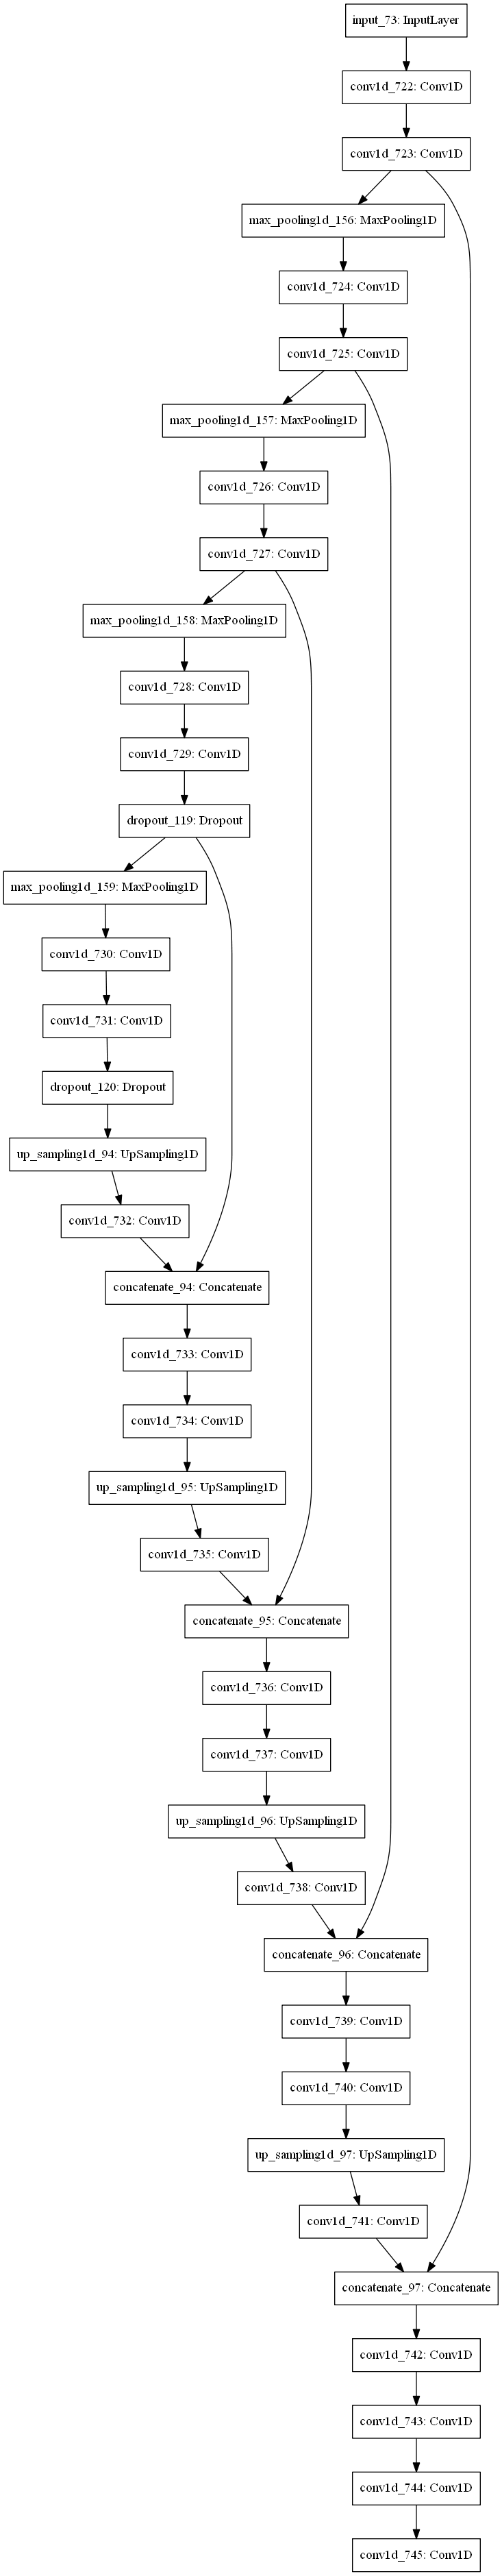

In [198]:
plot_model(model, to_file='model.png')
Image(filename='model.png', retina=True)

In [199]:
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

Lets prepare the train and test data for the model.

NOTE: For the Wave U-Net model, all files are going to be chuncked to 32k frames due to the model input and output shapes.

In [331]:
X, y = chunk4unet(df, 'data', 'incompleted_data')

In [332]:
X = np.reshape(X, (np.shape(X)[0], np.shape(X)[1], 1))
y = np.reshape(y, (np.shape(y)[0], np.shape(y)[1], 1))

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [361]:
model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=0)

In [365]:
# Audio to predict
fil = 15
# Reshape for the predict
pred_inp = np.reshape(X_test[fil], (1, np.shape(X_test[fil])[0], 1))
# Predict the file
pred_outp = model.predict(pred_inp)
# Reshape to play as wav
audio_output = np.reshape(pred_outp, (np.shape(pred_outp)[1]))
ipd.Audio(audio_output, rate=16000)

In [363]:
pred_inp = np.reshape(X_test[fil], (1, np.shape(X_test[fil])[0], 1))

In [366]:
audio_output

array([-0.00015458, -0.00015458, -0.00015458, ..., -0.00015458,
       -0.00015458, -0.00015458], dtype=float32)

## Results

In [347]:
stoppp

NameError: name 'stoppp' is not defined

In [15]:
print('Lets check some values:\n')

for i in range(0, 9):
    
    print('File',i,'\tMax:',np.amax(predicted[i]),' Min:',np.amin(predicted[i]))
    
    if option == 1:
        wavfile.write(('Predicted/Autoencoders/File_'+'{}'.format(i))+'.wav', 16000, predicted[i])
    if option == 2:
        wavfile.write(('Predicted/Convolutions/File_'+'{}'.format(i))+'.wav', 16000, predicted[i])

Lets check some values:



NameError: name 'predicted' is not defined